# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import math

# Useful functions 
def gaussianKernel(sigma):
    N = np.int(np.ceil(3*sigma))
    x = y = np.linspace(np.int(-3*sigma),np.int(3*sigma),2*N+1)
    X,Y = np.meshgrid(x,y)
    noyau = np.exp(-(X*X+Y*Y)/(2*sigma*sigma))
    return noyau/noyau.sum()

  
def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Gy = Gx.T  
    Ix = sp.convolve2d(image,Gx,mode='same')
    Iy = sp.convolve2d(image,Gy,mode='same')
    
    gauss = gaussianKernel(scale)
    
    A = sp.convolve2d(Ix*Ix, gauss, mode='same')
    BC = sp.convolve2d(Ix*Iy, gauss, mode='same')
    D = sp.convolve2d(Iy*Iy, gauss, mode='same')
    
    return A*D - BC*BC - kappa*(A+D)**2


2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

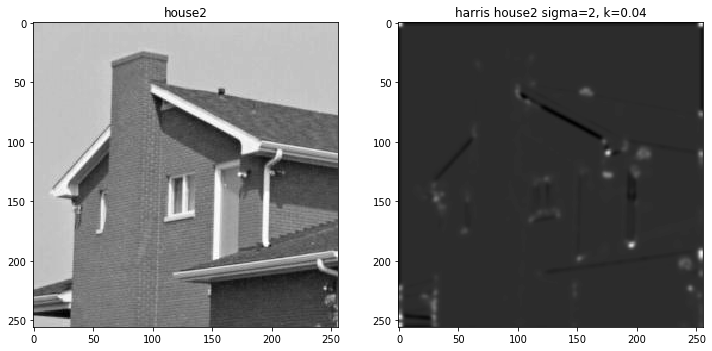

In [3]:
house2= np.array(Image.open("img/house2.png"))
niceDisplay14([house2,computeR(house2, 2, 0.04)],["house2","harris house2 sigma=2, k=0.04"])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Le détecteur de Harris distingue les zones homogènes, les contours et les coins grâce à la valeur $R(x,y)$ calculée. En effet :
- Si $R(x,y) < 0$ : c'est un contour
- Si $R(x,y) ≈ 0$ : c'est une zone homogène
- Si $R(x,y) > 0$ : c'est un coin

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [4]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R<thres, 0, 1) 

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [5]:
def rnms(R, Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    N,M = R.shape
    res = np.zeros((N,M))
    R = np.pad(R, 1)
    for x in range(1,N):
        for y in range(1,M):
            test=True
            if(Rbin[x,y]==1):
                for dx in range(-1,2):                    
                    if(test==False):
                        break                        
                    for dy in range(-1,2):                        
                        if(R[x,y]<R[x+dx,y+dy]):
                            test=False
                            break                            
                if(test==True):            
                    res[x-1,y-1]=1  
    return res

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [6]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R=computeR(image, scale, kappa)
    return rnms(R,thresholdR(R, thres))

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

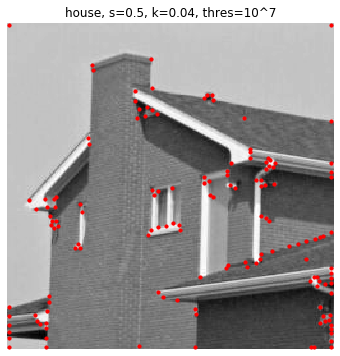

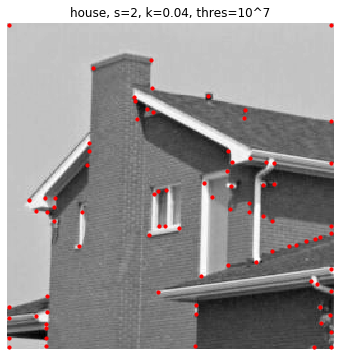

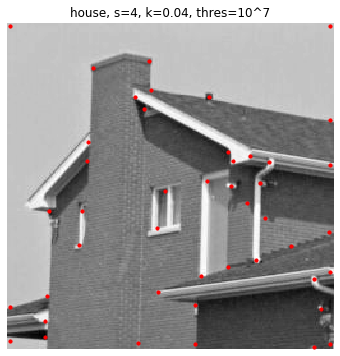

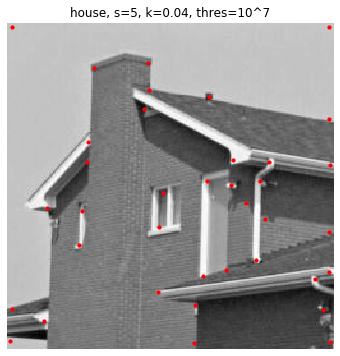

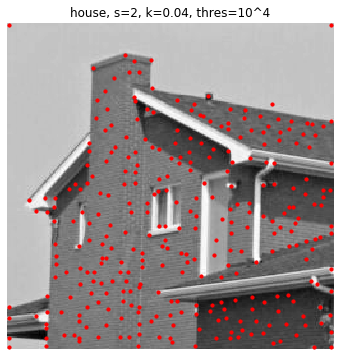

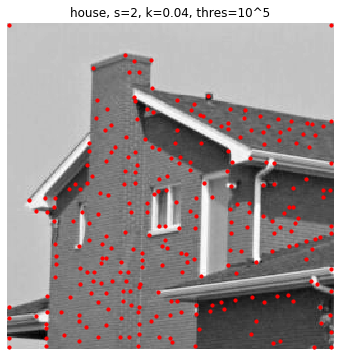

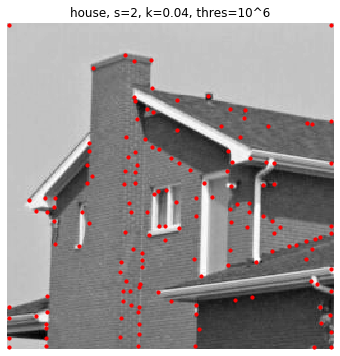

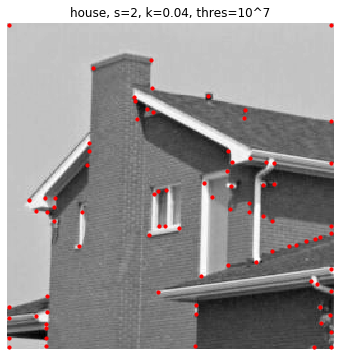

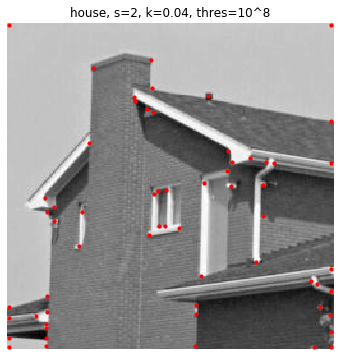

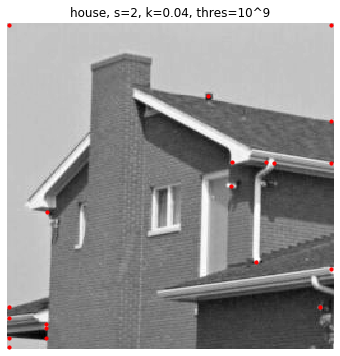

In [7]:
def displayCorner(image,scale,kappa,thres,title=None):
    image_cornered=cornerDetector(image,scale,kappa,thres)
    plt.figure(figsize=(500//80, 500//80))
    plt.gray()
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(image,vmin=0,vmax=255)
    plt.scatter(np.nonzero(image_cornered)[1],np.nonzero(image_cornered)[0], color='red',s=10)
    plt.show()

displayCorner(house2,0.5,0.04,10**7,"house, s=0.5, k=0.04, thres=10^7")
displayCorner(house2,2,0.04,10**7,"house, s=2, k=0.04, thres=10^7")
displayCorner(house2,4,0.04,10**7,"house, s=4, k=0.04, thres=10^7")
displayCorner(house2,5,0.04,10**7,"house, s=5, k=0.04, thres=10^7")

displayCorner(house2,2,0.04,10**4,"house, s=2, k=0.04, thres=10^4")
displayCorner(house2,2,0.04,10**5,"house, s=2, k=0.04, thres=10^5")
displayCorner(house2,2,0.04,10**6,"house, s=2, k=0.04, thres=10^6")
displayCorner(house2,2,0.04,10**7,"house, s=2, k=0.04, thres=10^7")
displayCorner(house2,2,0.04,10**8,"house, s=2, k=0.04, thres=10^8")
displayCorner(house2,2,0.04,10**9,"house, s=2, k=0.04, thres=10^9")

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

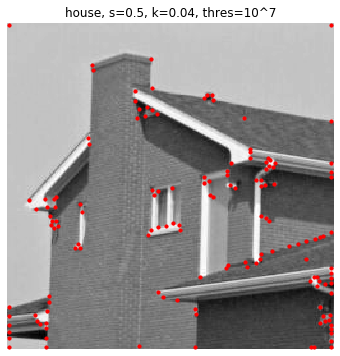

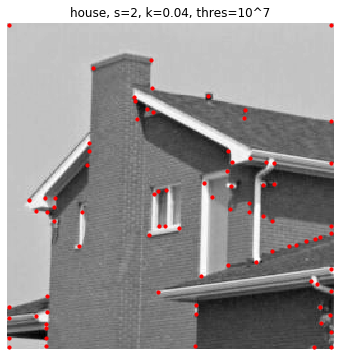

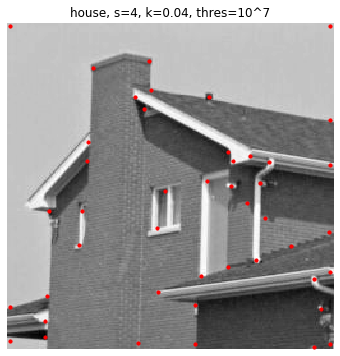

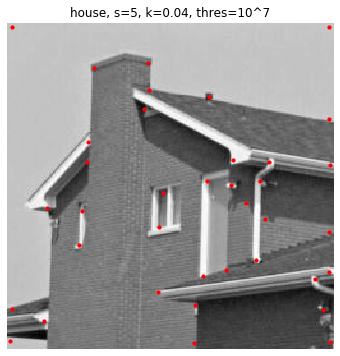

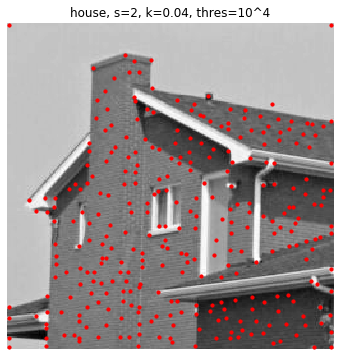

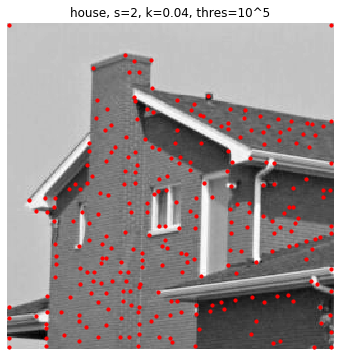

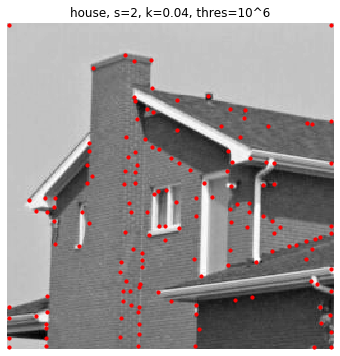

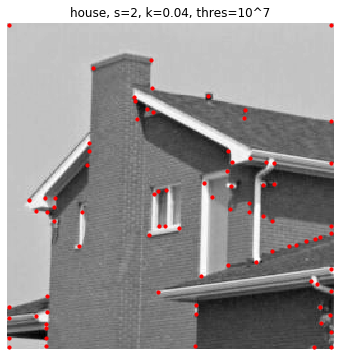

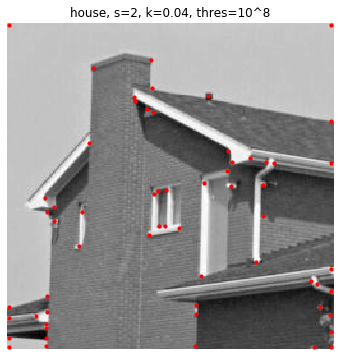

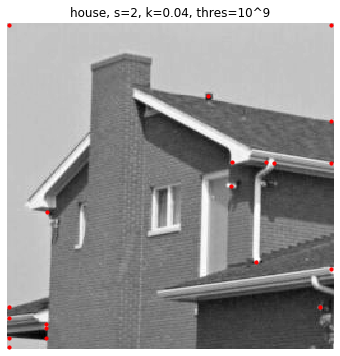

In [8]:
displayCorner(house2,0.5,0.04,10**7,"house, s=0.5, k=0.04, thres=10^7")
displayCorner(house2,2,0.04,10**7,"house, s=2, k=0.04, thres=10^7")
displayCorner(house2,4,0.04,10**7,"house, s=4, k=0.04, thres=10^7")
displayCorner(house2,5,0.04,10**7,"house, s=5, k=0.04, thres=10^7")

displayCorner(house2,2,0.04,10**4,"house, s=2, k=0.04, thres=10^4")
displayCorner(house2,2,0.04,10**5,"house, s=2, k=0.04, thres=10^5")
displayCorner(house2,2,0.04,10**6,"house, s=2, k=0.04, thres=10^6")
displayCorner(house2,2,0.04,10**7,"house, s=2, k=0.04, thres=10^7")
displayCorner(house2,2,0.04,10**8,"house, s=2, k=0.04, thres=10^8")
displayCorner(house2,2,0.04,10**9,"house, s=2, k=0.04, thres=10^9")

On observe que plus sigma est grand, plus détecteur trouve des coins, et plus sigma est petit, moins il en trouve.
On observe également que le seuillage semble efficace pour une valeur du seuil aux alentours de $10^7$. En effet, en dessous, on remarque que le détecteurs trouve des coins qui ne le sont pas, et au dessus, on observe que certains coins ne sont pas détectés.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

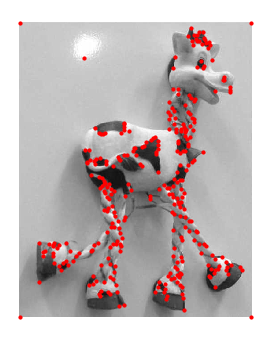

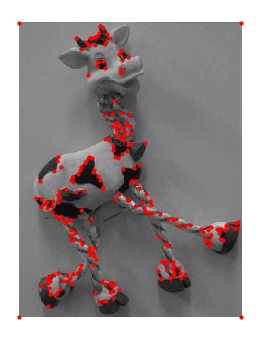

In [9]:
toyHorse1= np.array(Image.open("img/toyHorse1.png"))
toyHorse2= np.array(Image.open("img/toyHorse2.png"))

displayCorner(toyHorse1,2,0.04,10**7)
displayCorner(toyHorse2,2,0.04,10**7)

2) What are the dynamic ranges of these two images ?

In [10]:
def computeHistogram(I):
    """ Array -> list[int] """
    H=np.zeros(256)
    m,n = I.shape
    for i in range(m):
        for j in range(n):
            H[I[i,j]]+=1
    return H

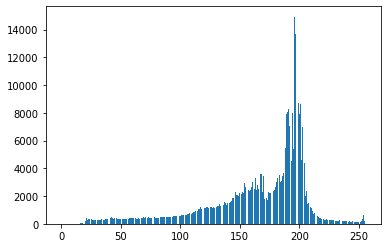

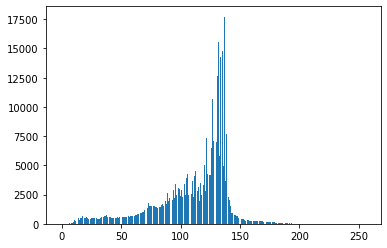

Dynamic range L pour toyHorse1 : L = 254
Dynamic range L pour toyHorse2 : L = 253


In [11]:
H_toyHorse1=computeHistogram(toyHorse1)
plt.bar(range(len(H_toyHorse1)),H_toyHorse1)
plt.show()

H_toyHorse2=computeHistogram(toyHorse2)
plt.bar(range(len(H_toyHorse2)),H_toyHorse2)
plt.show()

print("Dynamic range L pour toyHorse1 : L =", np.max(toyHorse1) - np.min(toyHorse1))
print("Dynamic range L pour toyHorse2 : L =",np.max(toyHorse2) - np.min(toyHorse2))

3) What are the transformations beetween the two images ?

Entre les 2 images, on a une rotation de l'objet et un changement de luminosité.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

In [12]:
def rotateImage(I,a):
    """ Array*float -> Array 
        return a rotation of angle a (degree) of image I
    """
    return np.array(Image.fromarray(I).rotate(a, expand=True, fillcolor=127))

In [13]:
toyHorse1_rotated_30 = rotateImage(toyHorse1,30)
toyHorse1_rotated_45 = rotateImage(toyHorse1,45)
toyHorse1_rotated_90 = rotateImage(toyHorse1,90)

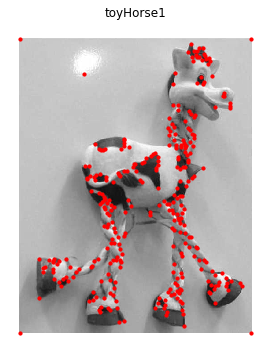

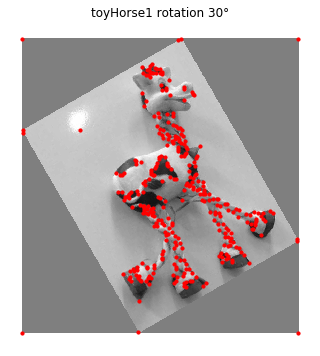

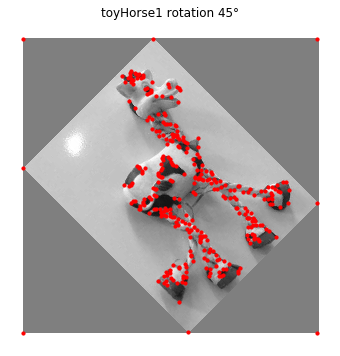

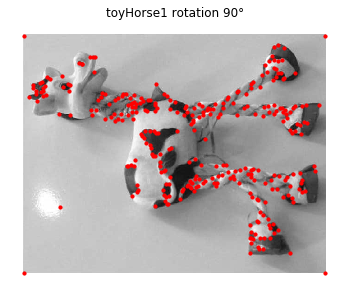

In [14]:
displayCorner(toyHorse1,2,0.04,10**7,"toyHorse1")
displayCorner(toyHorse1_rotated_30,2,0.04,10**7,"toyHorse1 rotation 30°")
displayCorner(toyHorse1_rotated_45,2,0.04,10**7,"toyHorse1 rotation 45°")
displayCorner(toyHorse1_rotated_90,2,0.04,10**7,"toyHorse1 rotation 90°")

En effectuant une rotation de l'image toyHorse1, on observe que le détecteur retrouve les mêmes coins, donc le détecteur de harris est invariant à la rotation.

In [15]:
def brightness_transformation(I,a,b):
    n,m=I.shape
    J=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            J[i,j]=(I[i,j]*a) +b
    return J

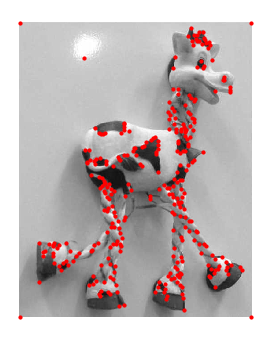

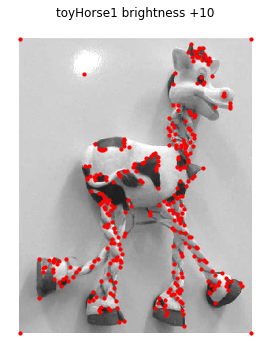

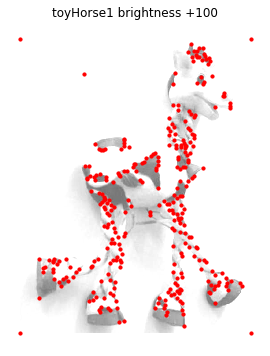

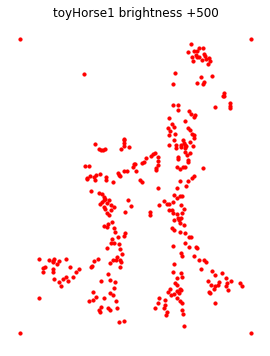

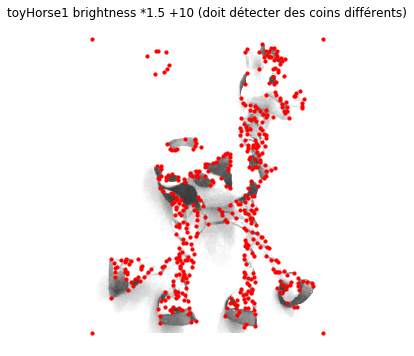

In [16]:
displayCorner(toyHorse1,2,0.04,10**7)
displayCorner(brightness_transformation(toyHorse1,1,10),2,0.04,10**7,"toyHorse1 brightness +10")
displayCorner(brightness_transformation(toyHorse1,1,100),2,0.04,10**7,"toyHorse1 brightness +100")
displayCorner(brightness_transformation(toyHorse1,1,500),2,0.04,10**7,"toyHorse1 brightness +500")
displayCorner(brightness_transformation(toyHorse1,1.5,30),2,0.04,10**7,"toyHorse1 brightness *1.5 +10 (doit détecter des coins différents)")

On sait qu'un coin peut être détecter lorsque l'on a un changement d'intensité important entre dse pixels voisins.
Soit $M$ la matrice représentant l'intensité de gris de chaque pixel dans l'image. Si le détecteur de Harris est invariant aux transformations affines de la luminosité, alors pour une image $M' = a * M + b$, on doit retrouver les mêmes coins avec le détecteur.

Le détecteur de Harris est invariant seulement aux changements additives d'intensité, c'est à dire lorsqu'on ajoute ou retire à chaque pixel la même intensité (car la luminosité de l'image change mais le contraste entre chaque pixels reste le même), soit $M' = M + b$.

En revanche elle n'est pas invariant à une multiplication, soit $M' = a*M$. Ceci est normal car une multiplication modifierai le contraste entre les pixels.

On conclut alors que le détecteur de Harris n'est pas invariant face aux transformations affines de la luminosité. Il serait invariant uniquement pour $a = 1$

Donc le détecteur de Harris est invariant à la rotation, mais pas à la transformation affine de la luminosité.